In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from sklearn.preprocessing import StandardScaler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
import os
from PIL import Image

In [5]:
dataset_folder = '/content/drive/MyDrive/Tyre Quality'
img_path = '/content/drive/MyDrive/Tyre Quality/training/defective/Defective (1).jpg'
training_dataset_path = '/content/drive/MyDrive/Tyre Quality/training'
testing_dataset_path = '/content/drive/MyDrive/Tyre Quality/testing'
classes = sorted(os.listdir(dataset_folder + '/training'))

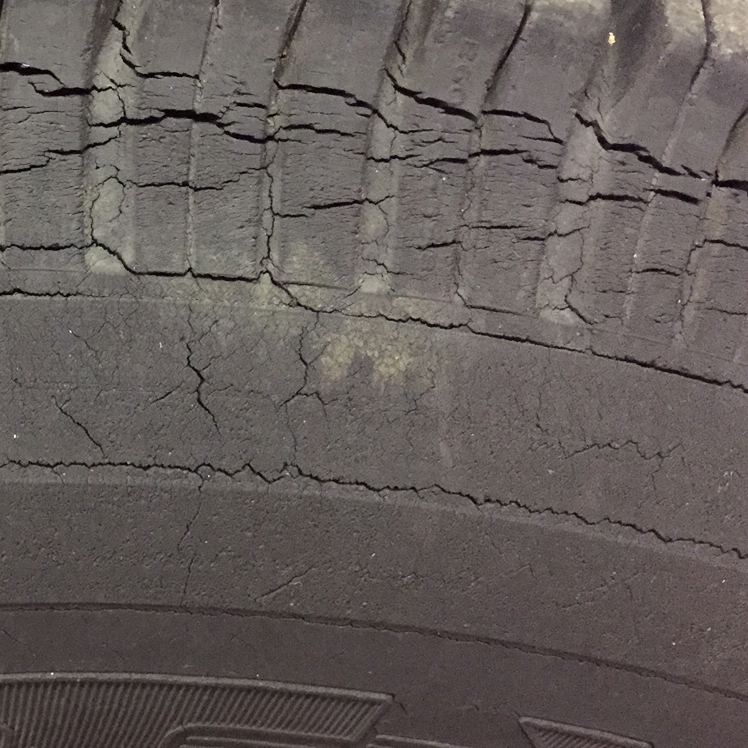

In [6]:
img = Image.open(img_path)
img

In [7]:
classes

['defective', 'good']

In [8]:
import numpy as np

In [9]:
np.random.seed(0)
torch.manual_seed(0)

In [10]:
from PIL import ImageOps, ImageFilter
import torchvision.transforms.functional as F
from torchvision import transforms

In [11]:
# Transformation function with fixed resize
def image_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform



In [12]:
transform = image_transform()

In [13]:
import torchvision
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [14]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 9128
    Root location: /content/drive/MyDrive/Tyre Quality/training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [15]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 390
    Root location: /content/drive/MyDrive/Tyre Quality/testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [17]:
def show_transformed_image(image_path, transform):
    # Load image
    img = Image.open(image_path)

    # Apply the transformations
    transformed_img = transform(img)

    # Convert the tensor back to numpy array for visualization
    img_np = transformed_img.numpy().transpose((1, 2, 0))  # Convert to HWC format for matplotlib

    # Undo normalization to bring values back to [0, 1] range
    img_np = img_np * 0.5 + 0.5  # Reverse normalization: img_np = (img_np * std + mean)

    # Display the transformed image
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

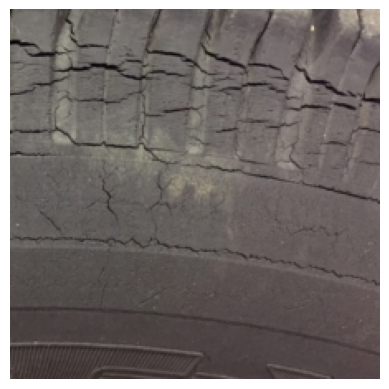

In [18]:
# Get the image transformation pipeline
transform = image_transform()

# Show the transformed image
show_transformed_image(img_path, transform)

In [19]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 16,shuffle=True)

In [20]:
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset

In [21]:
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size)) #0.2 - 30:70 Ratio
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 16,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=16, sampler=val_sampler)

In [22]:
import torch.nn as nn
import torchvision.models as models

In [23]:
vgg = models.vgg16(pretrained=True)
vgg_features = nn.Sequential(*list(vgg.children())[:-1])
vgg_features.eval()

for param in vgg_features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 119MB/s]


In [24]:
import torch.nn.functional as F

# Updated feature extraction with adaptive pooling
def extract_features(loader, model, output_size=(7, 7)):
    features_list = []
    with torch.no_grad():
        for images, _ in loader:
            # Pass the images through the VGG model to get the features
            features = model(images)
            # Apply adaptive pooling to standardize the feature map size
            pooled_features = F.adaptive_avg_pool2d(features, output_size)
            features_list.append(pooled_features.view(pooled_features.size(0), -1).cpu().numpy())  # Flatten
    return features_list


In [25]:
train_features = extract_features(test_loader, vgg_features)
val_features = extract_features(val_loader, vgg_features)

In [26]:
train_features = torch.tensor(np.concatenate(train_features, axis=0))
val_features = torch.tensor(np.concatenate(val_features, axis=0))

In [27]:
def extract_features_for_visualization(loader, model, output_size=(7, 7)):
    features_list = []
    with torch.no_grad():
        for images, _ in loader:
            features = model(images)
            pooled_features = F.adaptive_avg_pool2d(features, output_size)
            features_list.append(pooled_features.cpu())
    return features_list

# Extract features for visualization
train_features_for_vis = extract_features_for_visualization(train_loader, vgg_features)


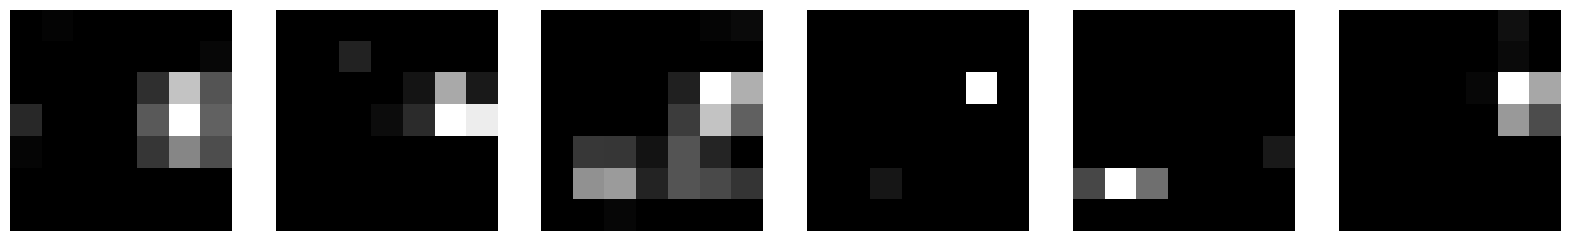

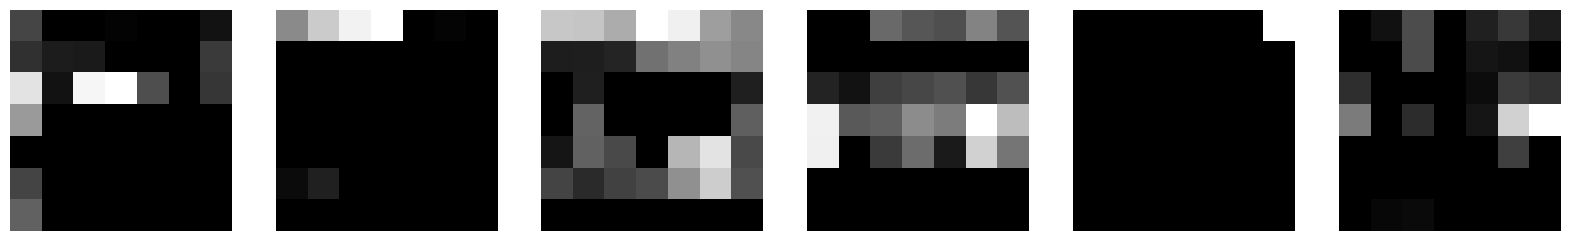

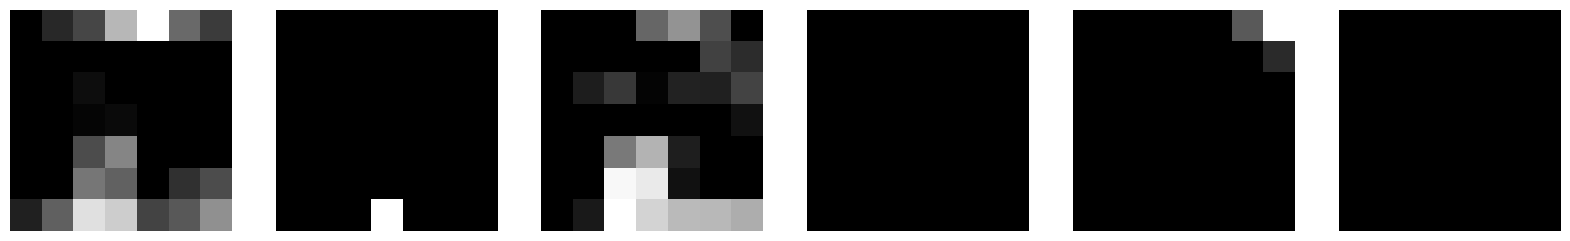

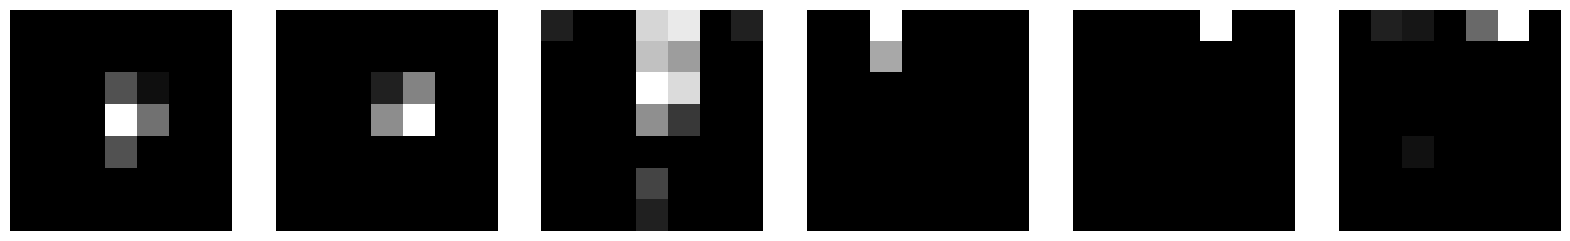

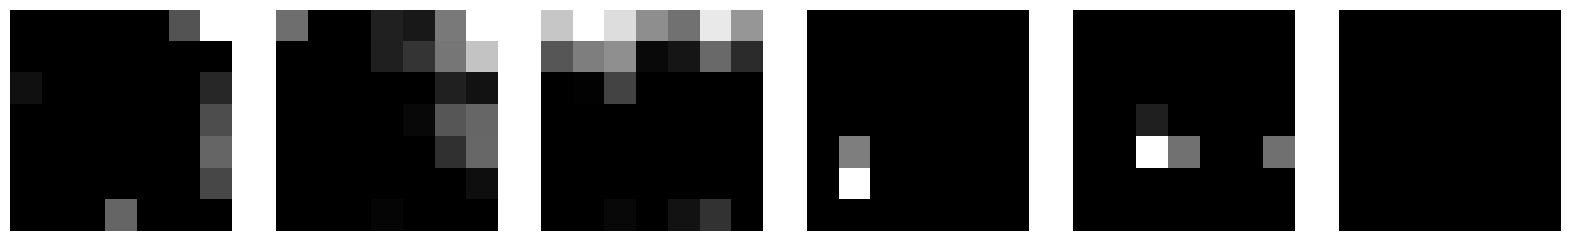

In [28]:
import matplotlib.pyplot as plt

def visualize_feature_maps(features, num_images=5, num_channels=6):
    for i in range(num_images):
        fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
        for j in range(num_channels):
            feature_map = features[i][0][j]  # Select the feature map for the i-th image and j-th channel
            axes[j].imshow(feature_map.detach().numpy(), cmap='gray')
            axes[j].axis('off')
        plt.show()

# Visualize first 5 images with 6 channels
visualize_feature_maps(train_features_for_vis, num_images=5, num_channels=6)


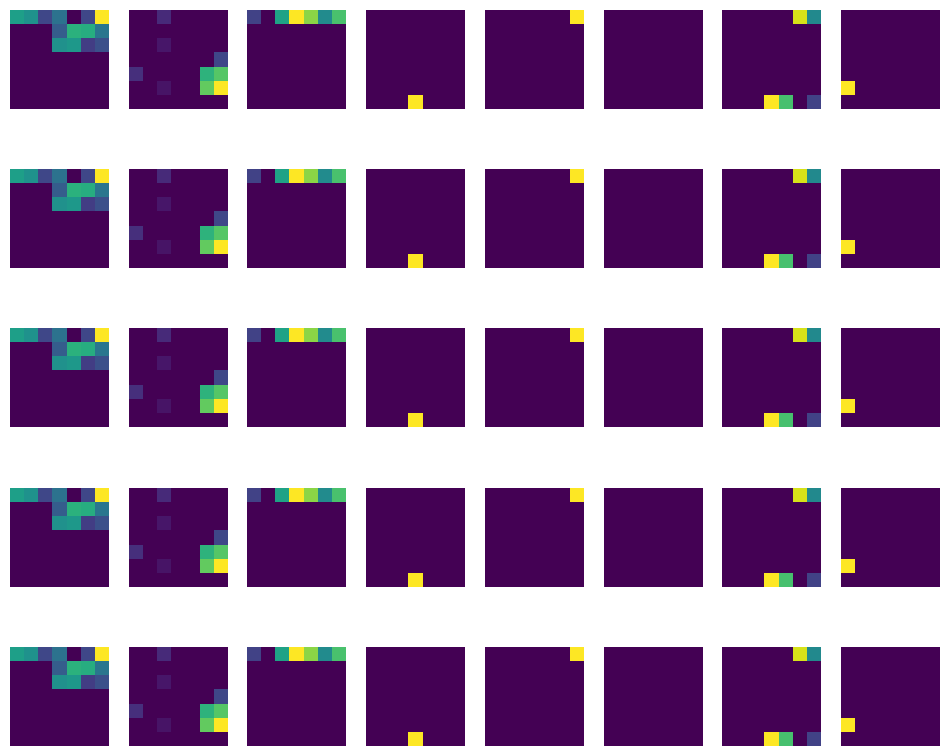

In [29]:
import torch
import matplotlib.pyplot as plt

# Function to visualize feature maps
def visualize_feature_maps(model, image, layers=[0, 5, 10, 17, 24]):
    model.eval()
    fig, axes = plt.subplots(len(layers), 8, figsize=(12, len(layers) * 2))

    for idx, layer_idx in enumerate(layers):
        x = image.unsqueeze(0)  # Add batch dimension for each layer

        # Forward pass up to the selected layer
        x = model[:layer_idx+1](x)

        # Get the first 8 feature maps
        for i in range(8):
            ax = axes[idx, i]
            ax.imshow(x[0, i].detach().cpu().numpy(), cmap='viridis')
            ax.axis('off')
        axes[idx, 0].set_ylabel(f'Layer {layer_idx}')
    plt.show()

img_tensor = transform(img)
visualize_feature_maps(vgg_features, img_tensor)


In [30]:
# Flatten features for SVM input
X_train = np.vstack(train_features)  # Each entry should be of the same flattened size now
X_val = np.vstack(val_features)

In [31]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm

In [32]:
# Adjusted to extract features and corresponding labels consistently
def extract_features_and_labels(loader, model, output_size=(7, 7)):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in loader:
            # Pass images through the model to get features
            features = model(images)
            # Apply adaptive pooling to ensure fixed output size
            pooled_features = F.adaptive_avg_pool2d(features, output_size)
            # Flatten pooled features
            flattened_features = pooled_features.view(pooled_features.size(0), -1)
            features_list.append(flattened_features.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())  # Collect corresponding labels
    return np.vstack(features_list), np.array(labels_list)

# Extract features and labels for training and validation sets
X_train, y_train = extract_features_and_labels(train_loader, vgg_features)
X_val, y_val = extract_features_and_labels(val_loader, vgg_features)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train and evaluate the SVM
svm_classifier = svm.SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"SVM Classification Accuracy: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"SVM Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
# For multiclass, binarize labels
if len(set(y_val)) > 2:
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    y_pred_proba_binarized = svm_classifier.predict_proba(X_val)
    auc = roc_auc_score(y_val_binarized, y_pred_proba_binarized, average="weighted", multi_class="ovr")
else:
    y_pred_proba = svm_classifier.predict_proba(X_val)[:, 1]  # Extract probabilities for positive class
    auc = roc_auc_score(y_val, y_pred_proba)
print(f"SVM Classification AUC: {auc:.2f}")



SVM Classification Accuracy: 94.02%
SVM Classification F1 Score: 0.94
SVM Classification AUC: 0.99


In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss

In [34]:
# Predict probabilities for loss computation
y_pred_proba = svm_classifier.predict_proba(X_val)

# Calculate Loss (Log Loss)
loss = log_loss(y_val, y_pred_proba)
print(f"SVM Classification Log Loss: {loss:.4f}")

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"SVM Classification Accuracy: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"SVM Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(y_val)) > 2:
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    auc = roc_auc_score(y_val_binarized, y_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(y_val, y_pred_proba[:, 1])
print(f"SVM Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
print(f"SVM Classification Precision: {precision:.2f}")
print(f"SVM Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")

SVM Classification Log Loss: 0.1332
SVM Classification Accuracy: 94.02%
SVM Classification F1 Score: 0.94
SVM Classification AUC: 0.99
SVM Classification Precision: 0.94
SVM Classification Recall: 0.94
Metric         : Value
Accuracy       : 94.02%
F1 Score       : 0.94
AUC            : 0.99
Log Loss       : 0.1332
Precision      : 0.94
Recall         : 0.94


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Train Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict labels
y_pred = rf_classifier.predict(X_val)

# Predict probabilities for loss and AUC computation
y_pred_proba = rf_classifier.predict_proba(X_val)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Random Forest F1 Score: {f1:.2f}")

# Calculate Log Loss
loss = log_loss(y_val, y_pred_proba)
print(f"Random Forest Log Loss: {loss:.4f}")

# Calculate AUC Score
if len(set(y_val)) > 2:
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    auc = roc_auc_score(y_val_binarized, y_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(y_val, y_pred_proba[:, 1])
print(f"Random Forest AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
print(f"Random Forest Precision: {precision:.2f}")
print(f"Random Forest Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Random Forest Accuracy: 88.03%
Random Forest F1 Score: 0.88
Random Forest Log Loss: 0.3237
Random Forest AUC: 0.96
Random Forest Precision: 0.88
Random Forest Recall: 0.88
Metric         : Value
Accuracy       : 88.03%
F1 Score       : 0.88
AUC            : 0.96
Log Loss       : 0.3237
Precision      : 0.88
Recall         : 0.88


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Train Logistic Regression model
log_reg_classifier = LogisticRegression(max_iter=1000)
log_reg_classifier.fit(X_train, y_train)

# Predict labels
y_pred = log_reg_classifier.predict(X_val)

# Predict probabilities for loss and AUC computation
y_pred_proba = log_reg_classifier.predict_proba(X_val)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Logistic Regression F1 Score: {f1:.2f}")

# Calculate Log Loss
loss = log_loss(y_val, y_pred_proba)
print(f"Logistic Regression Log Loss: {loss:.4f}")

# Calculate AUC Score
if len(set(y_val)) > 2:
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    auc = roc_auc_score(y_val_binarized, y_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(y_val, y_pred_proba[:, 1])
print(f"Logistic Regression AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
print(f"Logistic Regression Precision: {precision:.2f}")
print(f"Logistic Regression Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")



Logistic Regression Accuracy: 96.58%
Logistic Regression F1 Score: 0.97
Logistic Regression Log Loss: 0.1774
Logistic Regression AUC: 0.99
Logistic Regression Precision: 0.97
Logistic Regression Recall: 0.97
Metric         : Value
Accuracy       : 96.58%
F1 Score       : 0.97
AUC            : 0.99
Log Loss       : 0.1774
Precision      : 0.97
Recall         : 0.97


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Train k-NN model
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Predict labels
y_pred = knn_classifier.predict(X_val)

# Predict probabilities for loss and AUC computation
y_pred_proba = knn_classifier.predict_proba(X_val)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"k-NN Accuracy: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"k-NN F1 Score: {f1:.2f}")

# Calculate Log Loss
loss = log_loss(y_val, y_pred_proba)
print(f"k-NN Log Loss: {loss:.4f}")

# Calculate AUC Score
if len(set(y_val)) > 2:
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    auc = roc_auc_score(y_val_binarized, y_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(y_val, y_pred_proba[:, 1])
print(f"k-NN AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
print(f"k-NN Precision: {precision:.2f}")
print(f"k-NN Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


k-NN Accuracy: 67.52%
k-NN F1 Score: 0.64
k-NN Log Loss: 3.7592
k-NN AUC: 0.81
k-NN Precision: 0.75
k-NN Recall: 0.68
Metric         : Value
Accuracy       : 67.52%
F1 Score       : 0.64
AUC            : 0.81
Log Loss       : 3.7592
Precision      : 0.75
Recall         : 0.68


In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Train Naive Bayes model
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predict labels
y_pred = nb_classifier.predict(X_val)

# Predict probabilities for loss and AUC computation
y_pred_proba = nb_classifier.predict_proba(X_val)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Naive Bayes F1 Score: {f1:.2f}")

# Calculate Log Loss
loss = log_loss(y_val, y_pred_proba)
print(f"Naive Bayes Log Loss: {loss:.4f}")

# Calculate AUC Score
if len(set(y_val)) > 2:
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    auc = roc_auc_score(y_val_binarized, y_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(y_val, y_pred_proba[:, 1])
print(f"Naive Bayes AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
print(f"Naive Bayes Precision: {precision:.2f}")
print(f"Naive Bayes Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")



Naive Bayes Accuracy: 85.47%
Naive Bayes F1 Score: 0.85
Naive Bayes Log Loss: 5.2371
Naive Bayes AUC: 0.85
Naive Bayes Precision: 0.85
Naive Bayes Recall: 0.85
Metric         : Value
Accuracy       : 85.47%
F1 Score       : 0.85
AUC            : 0.85
Log Loss       : 5.2371
Precision      : 0.85
Recall         : 0.85


In [39]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Train MLP model
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
mlp_classifier.fit(X_train, y_train)

# Predict labels
y_pred = mlp_classifier.predict(X_val)

# Predict probabilities for loss and AUC computation
y_pred_proba = mlp_classifier.predict_proba(X_val)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"MLP Classifier Accuracy: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"MLP Classifier F1 Score: {f1:.2f}")

# Calculate Log Loss
loss = log_loss(y_val, y_pred_proba)
print(f"MLP Classifier Log Loss: {loss:.4f}")

# Calculate AUC Score
if len(set(y_val)) > 2:
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)
    auc = roc_auc_score(y_val_binarized, y_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(y_val, y_pred_proba[:, 1])
print(f"MLP Classifier AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
print(f"MLP Classifier Precision: {precision:.2f}")
print(f"MLP Classifier Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")



MLP Classifier Accuracy: 98.29%
MLP Classifier F1 Score: 0.98
MLP Classifier Log Loss: 0.1106
MLP Classifier AUC: 1.00
MLP Classifier Precision: 0.98
MLP Classifier Recall: 0.98
Metric         : Value
Accuracy       : 98.29%
F1 Score       : 0.98
AUC            : 1.00
Log Loss       : 0.1106
Precision      : 0.98
Recall         : 0.98
